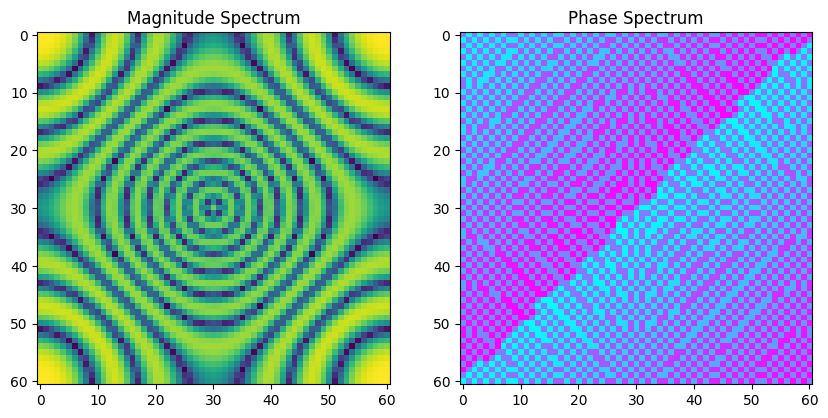
---


# 2D PHONONIC CRYSTAL NUMERICAL SOLVER#
A comprehensive toolkit to explore phononic behaviors in metamaterials. Analyze time and spatial profiles, perform FFT, generate animations, and derive numerical dispersion curves




In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import time
import math
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output, display
from numpy import exp,abs,abs,cos,sin,tan,exp,sinh,cosh,tanh,floor,ceil,exp,log10,log2,log
import json
from google.colab import files
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from numpy import savetxt
import pandas as pd

In the next section, modify the spring relation and damping model according to your preferences. Please note that 'Fomega' represents the linear frequency and **should not be altered**

In [7]:
# Important functions for the program
# just change the Spring and damping functions

def fomega2D(Kx,Ky):
    """
    Calculates the linear frequency based on the given wavenumber for 2D problems.

    Args:
    - Wavenumber (Kx,Ky): Wavenumber

    Returns:
    - Linear frequency
    """
    return np.sqrt( (2 - 2 * np.cos(Ky))  + (2 - 2 * np.cos(Kx)));

def fomega(Wavenumber):
    """
    Calculates the linear frequency based on the given wavenumber.

    Args:
    - Wavenumber: Wavenumber

    Returns:
    - Linear frequency
    """
    return np.sqrt(2 - 2 * np.cos(Wavenumber))

def springModel(x1, x2, t, element):
    """
    Calculates the displacement relation (F_u) based on the given inputs.

    Args:
    - x1: Displacement at point 1
    - x2: Displacement at point 2
    - t: Time parameter
    - element: Element parameter (if used)

    Returns:
    - Displacement relation (F_u)
    """
    x = x1 - x2  # Calculate displacement
    return x  # Return the displacement relation
    # Uncomment and modify below lines for alternative calculations
    # return x + 0.001 * np.abs(x)
    # return np.exp(-1 * x) * (1 - np.exp(-1 * x))

def dampingModel(x1, x2, x1_dot, x2_dot, t, element):
    """
    Calculates the damping relation (F_udot_u) based on the given inputs.

    Args:
    - x1: Displacement at point 1
    - x2: Displacement at point 2
    - x1_dot: Velocity at point 1
    - x2_dot: Velocity at point 2
    - t: Time parameter
    - element: Element parameter (if used)

    Returns:
    - Velocity relation (F_udot_u)
    """
    return 0; # No damping effect considered in this implementation; always returns 0
    # return -1*(1-(x1-x2)**2)*(x1_dot-x2_dot)
    # You can add damping calculations here if required

def setInitialCondition(node,wave_number,amplitude):
  """
    Sets the initial conditions for the system based on wave number and amplitude.

    Args:
    - wave_number: Wavenumber used to set initial conditions
    - amplitude: Amplitude used to set initial conditions

    Returns:
    - Initial conditions array
    """
  init            = np.zeros((node*2));
  for i in range(0,node,1):
    init[2*i]     = amplitude*np.cos(wave_number*i);
    init[2*i+1]   = amplitude*np.sin(wave_number*i)*fomega(wave_number);
  return init;

def setInitialCondition2D(node,Kx,Ky,particle,amplitude):
  """
    Sets the initial conditions for the system based on wave number and amplitude.

    Args:
    - wave_numbers (Kx,Ky): Wavenumbers used to set initial conditions
    - amplitude: Amplitude used to set initial conditions
    - Particle : the main node as a reference

    Returns:
    - Initial conditions array
    """
  table_pos = np.zeros((node,node))
  table_vel = np.zeros((node,node))
  init      = np.zeros(((node**2)*2))

  for i in range(0,node):
    for j in range(0,node):
      table_pos[i,j] = amplitude*cos((Kx*(particle - (i+1))) + Ky*(particle - (j+1)))
      table_vel[i,j] = fomega2D(Kx,Ky)*amplitude*sin((Kx*(particle - (i+1))) + Ky*(particle - (j+1)))

  init[0::2] = table_pos.flat[:];
  init[1::2] = table_vel.flat[:];
  return init


def getCenterNode(node):
    """
    Sets the initial conditions for the system based on wave number and amplitude.

    Args:
    - node: number of node in X and Y directions

    Returns:
    - center node
    """
    data = np.zeros((node, node))
    for i in range(node):
        for j in range(node):
            data[i, j] = 2 * (i * node + j )
    center_row = node // 2
    center_col = node // 2

    # Display the label of the center cell
    return (int(data[center_row, center_col]))

This is the core class of the program. Edit only if you know what you're doing

In [33]:
class numericalPCs:

  def __init__(self,node = 100,initial_condition = np.zeros(((100**2)*2)),time_step = 50,time_end = 300):
    # number of masses
    self.node      = node;
    self.totalNodes = node**2;
    self.totalComponents = self.totalNodes*2;
    # Set the initial condition (including wave number and amplitude)
    self.init      = initial_condition;
    # Set the time span for the simulation; these values facilitate our study for FFT
    self.sr        = time_step;
    self.ts        = 1.0/sr;
    self.time_end  = time_end;
    self.timing    = np.arange(0,time_end,self.ts);

  #Main function solving the dynamics using Runge-Kutta
  def run(self):
    sol = solve_ivp(self.oneDimSys, [0, self.time_end],self.init, args=(self.node,2),t_eval=self.timing);
    self.results          = sol.y;
    self.transposed_data  = np.transpose(sol.y)
    return self;

  # State-space
  def oneDimSys(self,t,z,node,data):
    totalNodes = self.totalNodes;
    totalComponents = self.totalComponents;
    Table = np.empty(shape=(totalNodes), dtype=object);
    iteratorOps = 0;
    for i in range(node**2):
            Table[i] = (iteratorOps, iteratorOps+1);
            iteratorOps = iteratorOps + 2;

    dy = np.zeros((totalComponents));
    for element in np.arange(0,totalNodes):
      current_pos = Table[element][0];
      current_vel = Table[element][1];
      dy[current_pos] = z[current_vel];

      if(current_pos == 0):
        direction = np.array([+2, -2, node*2, node*-2]);
      elif((element+1) % node == 0):
        direction = np.array([-2, node*2, node*-2 , 0]);
      elif((element) % node == 0):
        direction = np.array([+2, node*2, node*-2, 0]);
      else:
        direction = np.array([+2, -2, node*2, node*-2]);

      for innerLoopIter in direction:
        if((current_pos+innerLoopIter)>-1 and (current_pos+innerLoopIter)<totalComponents and innerLoopIter != 0):
          dy[current_vel] +=  -springModel(z[current_pos],z[current_pos+innerLoopIter],t,1)+  (-dampingModel(z[current_pos],z[current_pos+innerLoopIter],z[current_vel],z[current_vel+innerLoopIter],t,1))
        else:
          dy[current_vel] +=  -springModel(z[current_pos],0,t,1)+  (-dampingModel(z[current_pos],0,z[current_vel],0,t,1))
    return dy


  # Animating function
  def plot_anim(self,data,node,time_sample,frames,interval = 200,plt_type = 1,zlimit=[-1,1]):
    TData       = data[:,::2];
    x = np.linspace(0, node,node)
    y = np.linspace(0, node,node)
    x, y = np.meshgrid(x, y)

    if(plt_type == 1):
      fig, ax = plt.subplots()
    else:
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')

    def update(frame):
      ax.cla()
      if(frame == 0 ):
        cf = 0
      else:
        cf = int(np.floor(time_sample/frames)*(frame)) - 1

      newdata = TData[cf,:].reshape(node,node)
      if(plt_type == 2):
        contours = ax.plot_surface(x,y,newdata,cmap='viridis')
      else:
        contours = ax.contourf(x,y,newdata)
    self.ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval)
    return self.ani;


  # FFT & Plotting
  def FFT(self,x,sr):
    freq,fin_Y = self.FFrRaw(x,sr)
    fig        = go.Figure(data=go.Scatter(x=freq, y=fin_Y, mode='lines'))
    fig.update_layout(title='Line Plot',xaxis_title='',yaxis_title='FFt',)
    fig.show()
    return fig,freq,fin_Y

  # FFT calculation
  def FFrRaw(self,x,sr):
    X     = fft(x)
    N     = len(X)
    n     = np.arange(N)
    T     = N/sr
    freq  = (n/T)*2*np.pi;
    fin_Y = np.abs(X)

    return freq,fin_Y

  # Animation generation
  def animate(self,frame = 300,interval = 200,plt_type = 1,zlimit=[-1,1]):
    anim = self.plot_anim(self.transposed_data,self.node,self.timing.shape[0],frame,interval,plt_type,zlimit);
    return anim

  # Plot displacements
  def plotDetails(self):
    sr        = self.sr;
    ts        = self.ts;
    time_end  = self.time_end;
    t         = self.timing;
    node      = self.node;

    x     = self.transposed_data[:,0:node*2:2];
    X     = np.arange(0, node, 1)
    Y     = t/1000
    X, Y  = np.meshgrid(X, Y)

    fig   = plt.figure(figsize=(15, 10))
    gs    = fig.add_gridspec(2, 6)

    ax    = fig.add_subplot(gs[0, 0:3], projection='3d')
    surf  = ax.plot_surface(X, Y, x, cmap=cm.summer,linewidth=0);

    ax.view_init(azim=25, elev=30);
    ax.set_xlabel("Non-dimensional time (T1)")
    ax.set_ylabel("Mass number")
    ax.set_zlabel("Relative Displacment")
    ax.zaxis.labelpad=-0.7

    ax2 = fig.add_subplot(gs[0, 3:7])
    ax2.plot(t/100,x);
    ax2.set_xlabel("Non-dimensional time (T1)")
    ax2.set_ylabel("Relative Displacment")

    ax3 = fig.add_subplot(gs[1,:], projection='3d')
    for i in np.arange(1,node,20):
      ax3.plot3D(np.tile(np.array([i]), t.shape[0]), t/100, x[:,i])
    ax3.view_init(azim=45, elev=50);

    return self


  # Plots the spatial profile for a specific timestep.
  def spatialProfile(self,timestep = 1,figsize=(10,4)):
    x = np.linspace(0, node,node)
    y = np.linspace(0, node,node)
    x, y = np.meshgrid(x, y)
    overSpatial     = self.transposed_data[timestep,0::2].reshape(self.node,self.node);

    fig = plt.figure(figsize=(10, 5))
    # Plot the 3D surface
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(x, y, overSpatial, cmap='viridis')
    ax1.set_title('3D Surface Plot')


    # Plot the filled contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(x, y, overSpatial, cmap='viridis')
    ax2.set_title('Filled Contour Plot')
    plt.colorbar(contour)

    # Show the plot
    plt.tight_layout()
    plt.show()
    return self

  # Plots the history profile for a specific node.
  def historyProfile(self,node = 1,figsize=(10,4)):
    overHistory     = self.transposed_data[:,self.node];
    plt.figure(figsize=figsize);
    plt.plot(self.timing,overHistory);
    return self

  # Performs FFT (Fast Fourier Transform) on time history data for a specific node.
  def historyFFt(self,node = 1):
    overHistory       = self.transposed_data[:,node];
    fig1,freq1,fin_Y1 = self.FFT(overHistory,self.sr);
    return self

  # Performs FFT (Fast Fourier Transform) on spatial data for a specific timestamp.
  def SpatialFFt(self,timestamp = 1,direction = 0):
    node = self.node;
    if(direction == 0):
      # horizental
      start   = floor(node/2)*(node*2)
      stop    = start + (2*node)
      indices = np.arange(start, stop, 2)
    elif(direction == 1):
      # vertical
      start   = node-1
      stop    = (node)*(2*node)
      indices = np.arange(start, stop, node*2)
    else:
      # diagonal
      start   = 0
      stop    = (2*(node*node))
      indices = np.arange(start, stop, node*2+2)

    overspatial       = self.transposed_data[timestamp,indices.astype(int)];
    fig1,freq1,fin_Y1 = self.FFT(overspatial,sr);
    return self

  # Dispesion curve
  def Dispersion(self,time_end = 50,amplitude = 1,direction = 0):
    node        = self.node;
    particle    = ceil(node/2);
    time_end    = time_end;
    sr          = self.sr;
    amplitude   = amplitude;


    iter      = 0;
    WaveNumbers = np.arange(0,3.1,.3);
    for K in WaveNumbers:
      # First, set initial conditions with respect to wave number and amplitude
      if(direction == 0 ):
        K1 = K;
        K2 = 0;
      elif(direction == 1):
        K2 = K;
        K1 = np.pi;
      else:
        K2 = K;
        K1 = K;
      self.init      = (setInitialCondition2D(node,K1,K2,particle,amplitude))

      self.run();
      overHistory     = self.transposed_data[0:,getCenterNode(node)];
      # Perform FFT
      freq1,fin_Y1    = self.FFrRaw(overHistory,sr);
      pos             = np.where(freq1<3.4)
      # Store the data properly
      print("Currently at : ",K)
      if(iter > 0):
          MainData[:,iter] = fin_Y1[pos[0]]
          df.insert(iter+1, K, fin_Y1[pos[0]], True)
      else:
          df = pd.DataFrame({'x':freq1[pos[0]]})
          f1 = freq1[pos[0]];
          MainData = np.zeros((f1.shape[0],WaveNumbers.shape[0]))
          MainData[:,iter] = fin_Y1[pos[0]]
          df.insert(iter+1, K, fin_Y1[pos[0]], True)
      iter = iter+1

    # Plot the dispersion curve
    [X,Y] = np.meshgrid(f1.T,WaveNumbers)
    fig   = plt.figure()
    ax    = fig.subplots()
    ax.contourf(Y,X,MainData.T)

#Implementation

We'll begin utilizing our 'numericalPCs' class.

In [34]:
node        = 31  # @param {type:"slider", min:5, max:1000, step:1}
time_end    = 50 # @param {type: "number"}
sr          = 10  # @param {type: "slider", min: 10, max: 1000, step:1}
###############################################
# Write code manually for initial conditions
# If you encounter the variable 'k' anywhere, it represents the wave number
Kx                = 1;
Ky                = 1;
amplitude         = 0.0001 # @param {type: "number"}
init              = np.zeros(((node**2)*2));
###############################################
#inital condition is very important here

particle    = ceil(31/2);
init = (setInitialCondition2D(node,Kx,Ky,particle,amplitude))
# init[960] = 1;

# or use the helper
# init = setInitialCondition(node = node,wave_number = wave_number ,amplitude = amplitude)
###############################################

# Initializing the class
PC = numericalPCs(node = node,initial_condition = init,time_step = sr,time_end = time_end)

In the upcoming section, we'll solve the system's dynamics and proceed to analyze both its historical and spatial profiles

In [35]:
# Running the simulation for a specific initial condition
PC.run();

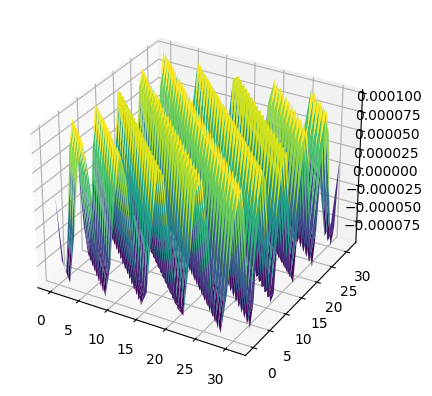

In [7]:
# Animating the profile for better perception
anim = PC.animate(frame=200,interval = 200,plt_type = 2,zlimit=[-.1,.1]);
HTML(anim.to_html5_video())

# or save
# Writer = animation.FFMpegWriter(fps=10)
# anim.save('animation.mp4', writer=Writer)

In [ ]:
# Ploting spatial profile
PC.spatialProfile(timestep=50)
PC.spatialProfile(timestep=100)
PC.spatialProfile(timestep=222)
PC.spatialProfile(timestep=555)
PC.spatialProfile(timestep=666)
PC.spatialProfile(timestep=777)
PC.spatialProfile(timestep=888)
PC.spatialProfile(timestep=999)



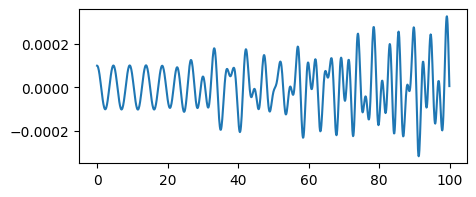

In [9]:
# Ploting spatial profile
PC.historyProfile(node=960,figsize=(5,2));

Text(0, 0.5, 'V')

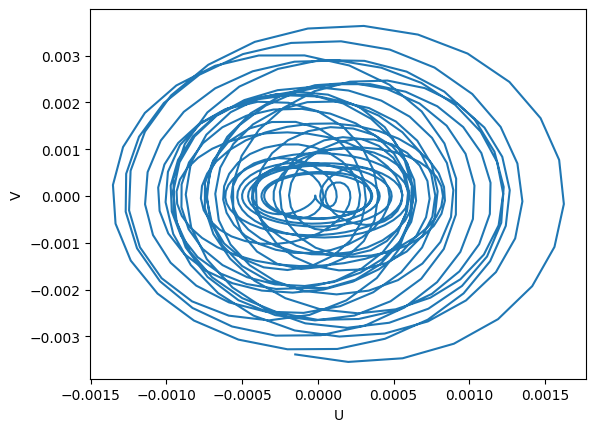

In [10]:
# proposed Phase diagram relation for the 2D chain
s1 = 4*PC.transposed_data[:,960] - PC.transposed_data[:,962] - PC.transposed_data[:,958] - PC.transposed_data[:,690-62] - PC.transposed_data[:,960+62]
s2 = 4*PC.transposed_data[:,961]- PC.transposed_data[:,962+1]- PC.transposed_data[:,958+1] - PC.transposed_data[:,(690-62)+1] - PC.transposed_data[:,(960+62)+1]
plt.plot(s1,s2)
plt.xlabel('U')
plt.ylabel('V')

In [39]:
# FFT over time history and spatial profile
PC.historyFFt(node = 960);

# FFT over spatial profile and the specefic direction
# Horizental direction =  0 (center line)
# Vertical   direction =  1 (center line)
# Diagonal   direction =  2 (start from first node placed at (1,1) )
PC.SpatialFFt(timestamp = 100,direction = 1)

# Dispersion Curve

The "direction" parameter in the dispersion function specifies the  path or line within the Brillouin zone along which the dispersion curve is calculated. Each path or line is represented by a unique identifier or number in the image below. By providing the appropriate "direction" value, the dispersion function can be extracted and plotted.


---



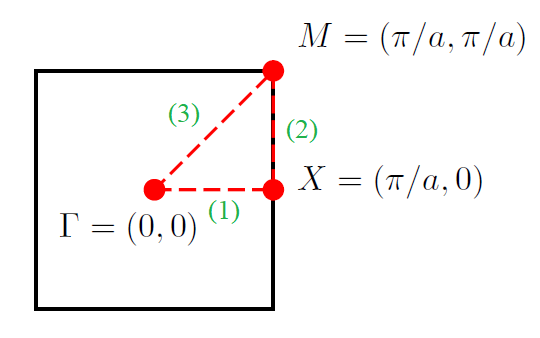


*   Γ-X (1)
*   X-M (2)
*   M-Γ (3)

Currently at :  0.0
Currently at :  0.3
Currently at :  0.6
Currently at :  0.8999999999999999
Currently at :  1.2
Currently at :  1.5
Currently at :  1.7999999999999998
Currently at :  2.1
Currently at :  2.4
Currently at :  2.6999999999999997
Currently at :  3.0


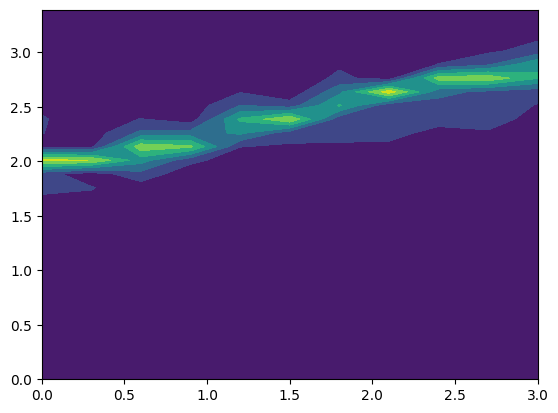

In [10]:
# plot dispersion curve for high-symmetry lines in the brillouin zone
PC.Dispersion(time_end = 50,amplitude = 1,direction = 1)

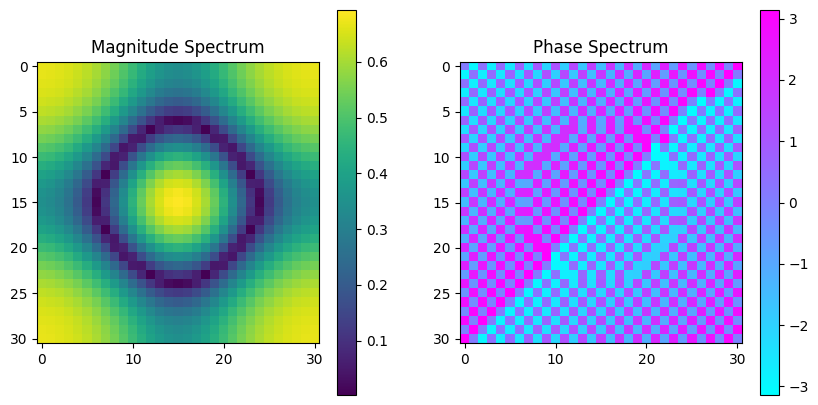

In [ ]:

# Perform 2D FFT
time = 1;
fft_result = np.fft.fft2(PC.transposed_data[time*sr,::2].reshape(node,node))

# Shift zero frequency component to the center
fft_shifted = np.fft.fftshift(fft_result)

# If you want to compute the magnitude spectrum
magnitude_spectrum = np.abs(fft_shifted)

# If you want to compute the phase spectrum
phase_spectrum = np.angle(fft_shifted)

# Optionally, you can visualize the magnitude spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.log(1 + magnitude_spectrum), cmap='viridis')
plt.title('Magnitude Spectrum')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(phase_spectrum, cmap='cool')
plt.title('Phase Spectrum')
plt.colorbar()
plt.show()
